In [1]:
import os
import time
import numpy as np
import scipy.io as sio
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import utils
import torch

# Define centered FFT routines
def fft2c(x):
    return fftshift(fft2(ifftshift(x), axes=(0,1)))

def ifft2c(x):
    return fftshift(ifft2(ifftshift(x), axes=(0,1)))

# --- PARAMETERS ---

# Laser
wl = 0.532  # Wavelength in micrometers

# GPD (Diffuser)
gpd_dir = os.path.join('microretarders_mfile.mat')  # File containing diffuser data
input_pol = 'R'    # Polarization: 'R' (or 'L')
gpd_flip = 1       # Flip diffuser horizontally if needed
gpd_pix = 30       # Diffuser pixel size in micrometers
gpd_size = (512, 512)  # Dimensions of diffuser grid

# Camera
cam_flip = 0                  # Camera flip flag
cam_pix = 3.1                 # Camera pixel size in micrometers
cam_crop_size = (1024, 1024)     # Cropped sensor size

# Lenses
f1 = 300000     # Focal length of lens 1 in micrometers
f2 = 200000     # Focal length of lens 2 in micrometers
mag = f2 / f1   # System magnification
gamma_min = 9   # Minimum gamma threshold

# Display
display_pix = 36  # Display pixel size in micrometers
M_disp = display_pix / cam_pix * f2 / f1  # Display magnification factor
display_size = (768, 1024)
# Ensure display size does not exceed camera crop size:
display_size = (min(display_size[0], cam_crop_size[0]), min(display_size[1], cam_crop_size[1]))
effRectSize = (display_size[0] * display_pix / M_disp, display_size[1] * display_pix / M_disp)  # Effective sample FOV in um

# Gamma Checks
diffFOV = (gpd_size[0] * gpd_pix, gpd_size[1] * gpd_pix)  # Diffuser FOV in micrometers
N_max = np.prod(np.array(effRectSize) * np.array(diffFOV) / (wl * f1))  # Max resolvable elements
M_gpd = np.prod(gpd_size)  # Total diffuser pixels
M_camera = np.prod(np.array(cam_crop_size) * cam_pix * np.array(diffFOV) / (wl * f2))  # Camera resolution elements

gamma_gpd = M_gpd / N_max
gamma_diff = M_camera / N_max

print(f" | max samSize: [{effRectSize[0]*1e-3:.2f}, {effRectSize[1]*1e-3:.2f}] mm")
print(f" | gamma_gpd  > gamma_min: {gamma_gpd:.2f} > {gamma_min}")
print(f" | gamma_diff > gamma_min: {gamma_diff:.2f} > {gamma_min}")

 | max samSize: [3.57, 4.76] mm
 | gamma_gpd  > gamma_min: 1.66 > 9
 | gamma_diff > gamma_min: 1.33 > 9


In [2]:
# --- Generate Diffuser Field ---
anglescan = -0.19867  # Rotation angle for the diffuser (deg)
magscan = 0.9985      # Magnification correction factor
"""
diffuser_E, _, GPDwindow = utils.gpdField(
    gpd_dir, gpd_size, gpd_pix, gpd_flip, input_pol,
    cam_crop_size, cam_pix, cam_flip, wl, f1, f2, effRectSize,
    gpdRot=-anglescan, gpdMag=1/magscan
)
"""
diffuser_E = sio.loadmat('diffuser_E.mat')
diffuser_E = diffuser_E['diffuserE']
cam_pix2 = (cam_pix, cam_pix)

In [3]:
# --- Sample Parameters & Optimization Settings ---
is_sample_circle = 1    # 1: Circular aperture, 0: Square aperture
sam_FOV = 1.2e3     # Sample FOV in micrometers

optimization_method = 'FISTA'
correlation_critical = 1e-4

In [4]:
# Define Sample Mask (samMask)
padSize = diffuser_E.shape
if is_sample_circle:
    # Calculate radii in pixel units:
    rr = (round(sam_FOV * mag / cam_pix2[0] / 2), round(sam_FOV * mag / cam_pix2[1] / 2))
    # Create circular mask (note: mk_ellipse returns True outside the ellipse)
    sample_mask = ~utils.mk_ellipse(rr[1], rr[0], padSize[1], padSize[0])
else:
    sample_mask_size = (round(sam_FOV * mag / cam_pix2[0]), round(sam_FOV * mag / cam_pix2[1]))
    sample_mask = np.ones(sample_mask_size, dtype=bool)
    sample_mask = utils.mpad(sample_mask, padSize)
    
# Crop the sample mask to the display size for SLM mapping.
sample_mask_SLM = utils.mcrop(sample_mask, display_size)
# Compute row/column indices with nonzero mask sums.
mask1 = np.where(np.sum(sample_mask_SLM, axis=1) > 0)[0]
mask2 = np.where(np.sum(sample_mask_SLM, axis=0) > 0)[0]

# (In this translation we stick with numpy arrays. For GPU acceleration, consider using cupy.)
sample_mask_SLM = sample_mask_SLM.copy()
sample_mask = sample_mask.copy()

# temporary
pad_size = (1024, 1024)
spk_window = utils.mpad(np.ones(cam_crop_size, dtype=bool), pad_size)

# Bring diffuser field to "GPU" memory and apply ifftshift.
X_iter_0 = 'random'  # Initial guess type for reconstruction

# --- Ramp Calculation for SLM Pattern ---
Y_grid, X_grid = utils.ndgrid_matSizeIn(display_size, 0, 'centerZero')
ramp = 2 * np.pi * ((X_grid * 0.5) + (Y_grid * 0.5))
ramp = ramp.astype(np.float32)


In [5]:
# --- SLM Calibration ---
phaseVal, SLMDigit = utils.SLM_LUT()

def phase2digit(x):
    # Convert phase values to SLM digit values using nearest interpolation.
    return np.interp(x, phaseVal, SLMDigit)

shiftvec = (10, 5)

In [6]:
import torch

def T(Xiter, diffuser_E, Y_domain=None):
    numel = np.prod(Xiter.shape[:2])
    # Explicitly use axes (0, 1) for the spatial dimensions
    temp = np.fft.fft2(Xiter, axes=(0, 1))
    temp = temp * diffuser_E
    Yiter = np.fft.fft2(temp, axes=(0, 1)) / numel
    if Y_domain is not None:
        Yiter = Yiter * Y_domain
    return Yiter

def T_dagger(Yiter, diffuser_E, X_domain=None):
    numel = np.prod(Yiter.shape[:2])
    temp = np.fft.fft2(np.conj(Yiter), axes=(0, 1))
    temp = temp * diffuser_E
    Xiter = np.conj(np.fft.fft2(temp, axes=(0, 1))) * X_domain / numel
    return Xiter

def T_cuda(Xiter, diffuser_E, Y_domain=None):
    X = Xiter
    E = diffuser_E
    Y_domain = Y_domain if Y_domain is not None else None

    numel = X.shape[0] * X.shape[1]
    temp = torch.fft.fft2(X, dim=(0,1))
    temp = temp * E
    Y = torch.fft.fft2(temp, dim=(0,1)) / numel
    if Y_domain is not None:
        Y = Y * Y_domain

    return Y

def T_dagger_cuda(Yiter, diffuser_E, X_domain=None):
    Y = Yiter
    E = diffuser_E
    X_domain = X_domain if X_domain is not None else 1.0

    numel = Y.shape[0] * Y.shape[1]
    temp = torch.fft.fft2(torch.conj(Y), dim=(0,1))
    temp = temp * E
    X = torch.conj(torch.fft.fft2(temp, dim=(0,1))) * X_domain / numel

    return X

<h1> Part 1 </h1>

In [7]:
# Configurations
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
gpu_ind = None
optimization_method = 'FISTA'

In [8]:
Y_domain = spk_window
iterMax=100
eta=0.5e-2
step_size=1
X_iter_0='random'
use_SSMinit=True

diffuser_E = ifftshift(diffuser_E)
sample_mask = np.roll(sample_mask, shift=(shiftvec[0], shiftvec[1]), axis=(0,1))

In [9]:
import os
import time
import numpy as np
import h5py

def load_mat_file(file_path):
    data = {}
    with h5py.File(file_path, 'r') as f:
        for key in f.keys():
            # Convert HDF5 datasets to numpy arrays.
            data[key] = np.array(f[key])
    return data

path = "rawImages-004.mat"
data = load_mat_file(path)
imgbuffer = data.get('imgbuffer')
imgbuffer = imgbuffer.transpose(1,2,0)

psi = imgbuffer[:,:,0:20].astype(np.float32)
psi = np.transpose(psi, axes=(1, 0, 2))
psi = np.real(np.sqrt(psi))

In [10]:
X_iter = sample_mask
Y_iter = T(X_iter, diffuser_E, Y_domain)
X_iter = T_dagger(Y_iter, diffuser_E, sample_mask)

In [11]:
# Compute maximum absolute value of Xiter in spatial dimensions
# (summing over the first two dims; assumes psi is at least 2D)
# Constant for scaling the step-size based on psi energy
phase_conj_delta = np.max(np.abs(X_iter), axis=(0, 1))
psi_energy = np.sum(psi**2, axis=(0,1))
eta_constant = np.sqrt(psi_energy / phase_conj_delta)

In [12]:
if optimization_method in ['GD', 'FISTA']:
    # Scale the step size elementwise
    step_size = step_size / phase_conj_delta
elif optimization_method in ['Adam', 'Nadam', 'AMSGrad']:
    eta = eta * eta_constant  # adjust eta with etaConstant
else:
    raise ValueError("Invalid opt_method")  # should not happen

In [13]:
# Make stack
if psi.shape[2] is not None:
    stack_num = psi.shape[2]
    diffuser_E = np.stack([diffuser_E] * stack_num, axis=2)
    sample_mask = np.stack([sample_mask] * stack_num, axis=2)
    Y_domain = np.stack([Y_domain] * stack_num, axis=2)

<h1> Part 2 </h1>

In [14]:
# Determine the padded size from psi
pad_size = psi.shape

# If X_iter_0 is specified as a string option, build it accordingly.
if isinstance(X_iter_0, str):
    if X_iter_0 == 'zero':
        X_iter_0 = np.zeros(pad_size, dtype=diffuser_E.dtype)
    elif X_iter_0 in ['random', 'SSM']:
        # Create a random complex guess within the sampling mask
        X_iter_0 = (np.random.randn(*diffuser_E.shape) +
                        1j * np.random.randn(*diffuser_E.shape)) * sample_mask

        # Replicate X_iter along the third dimension if necessary.
        if X_iter.ndim < len(pad_size):
            X_iter_0 = np.tile(X_iter[..., np.newaxis], (1, 1, pad_size[2]))
        else:
            X_iter_0 = X_iter

        # Ensure the type matches diffuser_E.
        X_iter_0 = X_iter_0.astype(diffuser_E.dtype)

        # Compute normalization: ensure that the masked energy of the random guess is unit scaled.
        norm_denom = np.sqrt(np.sum(np.abs(sample_mask * X_iter_0)**2, axis=(0, 1)) /
                                    np.sum(sample_mask))
        if norm_denom.ndim == 1:
            norm_denom = norm_denom[None, None, :]  # reshape for broadcasting

        # Normalize and scale by eta_constant.
        stack_X_iter = np.stack([X_iter]*sample_mask.shape[2], axis=2)
        X_iter_0 = (sample_mask * stack_X_iter) / norm_denom * eta_constant / 2
    else:
        raise ValueError("Invalid X_iter_0")
# If X_iter_0 is already provided as a numpy array (a matrix), leave it unchanged.
elif isinstance(X_iter_0, np.ndarray):
    X_iter_0 = X_iter_0
else:
    raise ValueError("Invalid X_iter_0")

<h1> Part 3 : SSM Initialization </h1>

In [15]:
X_iter = X_iter_0 / np.sqrt(np.sum(np.abs(X_iter_0)**2, axis=(0,1)))
dIyy = np.abs(psi)**2 - np.mean(np.abs(psi)**2)

In [16]:
from tqdm import tqdm

Y_iter = np.stack([Y_iter] * psi.shape[2], axis=2)

Y_iter_torch = torch.tensor(Y_iter).cuda()
X_iter_torch = torch.tensor(X_iter).cuda()
diffuser_E_torch = torch.tensor(diffuser_E).cuda()
Y_domain_torch = torch.tensor(Y_domain).cuda()
dIyy_torch = torch.tensor(dIyy).cuda()
sample_mask_torch = torch.tensor(sample_mask).cuda()

for i in tqdm(range(100), desc='SSM_Initialization'):
    Y_iter_torch = T_cuda(X_iter_torch, diffuser_E_torch, Y_domain_torch)
    X_iter_torch = T_dagger_cuda(dIyy_torch * Y_iter_torch, diffuser_E_torch, sample_mask_torch)
    X_iter_torch = X_iter_torch / torch.sqrt(torch.sum(torch.abs(X_iter_torch)**2, axis=(0,1)))

Y_iter = Y_iter_torch.cpu().numpy()
X_iter = X_iter_torch.cpu().numpy()
X_iter_0 = X_iter / (np.sqrt(np.sum(np.abs(sample_mask * X_iter) ** 2, axis=(0,1))/np.sum(sample_mask))) * eta_constant  / 2

SSM_Initialization: 100%|██████████| 100/100 [00:01<00:00, 67.93it/s]


<h1> Second Initialization </h1>

In [17]:
pad_size = psi.shape

if optimization_method=='GD':
    pass
elif optimization_method=='FISTA':
    t0 = 1
    grad_res = np.zeros(pad_size, dtype=X_iter_0.dtype)
elif optimization_method in {'Adam', 'Nadam', 'AMSGrad'}:
    m_map = np.zeros(pad_size, dtype=X_iter_0.dtype)
    v_map = np.zeros(pad_size, dtype=X_iter_0.dtype)
            
# Initial Forward Model
# Use machine epsilon based on psi’s floating-point type.
ep0 = np.finfo(psi.dtype).eps
X_iter = X_iter_0

<h1> Main Loop </h1>

In [18]:
Y_iter_torch = torch.tensor(Y_iter).cuda()
X_iter_torch = torch.tensor(X_iter).cuda()
diffuser_E_torch = torch.tensor(diffuser_E).cuda()
Y_domain_torch = torch.tensor(Y_domain).cuda()
psi_torch = torch.tensor(psi).cuda()
sample_mask_torch = torch.tensor(sample_mask).cuda()
grad_res_torch = torch.tensor(grad_res).cuda()

ep0_torch = torch.tensor(ep0).cuda()
step_size_torch = torch.tensor(step_size).cuda()
t0_torch = torch.tensor(t0).cuda()
sqrt2_torch = torch.tensor(np.sqrt(2)).cuda()


for i in tqdm(range(100), desc='main loop'):
    Y_iter_torch = T_cuda(X_iter_torch, diffuser_E_torch, Y_domain_torch)
    W_iter = torch.abs(Y_iter_torch) / (psi_torch + ep0_torch)
    mean_W_iter = torch.mean(W_iter, axis=(0,1))
    W_iter = W_iter / mean_W_iter
    
    normalization = torch.sqrt(W_iter**2 + mean_W_iter**(-2))
    y_vec = (mean_W_iter * normalization - sqrt2_torch) * (W_iter / (normalization + ep0_torch)) * psi_torch * torch.exp(1j * torch.angle(Y_iter_torch))
    
    # gradient
    g = T_dagger_cuda(y_vec, diffuser_E_torch, sample_mask_torch)
    old_grad_res = grad_res_torch
    grad_res_torch = X_iter_torch - step_size_torch * g
    t1 = (1 + torch.sqrt(1 + 4*(t0_torch**2)))/2
    beta = (t0_torch - 1) / t1
    t0_torch = t1
    X_iter_torch = grad_res_torch + beta * (grad_res_torch - old_grad_res)
    
X_final = X_iter_torch.cpu().numpy()

main loop: 100%|██████████| 150/150 [00:05<00:00, 28.15it/s]


<h1> Final step </h1>

In [19]:
gpd_window = sio.loadmat('GPD_window.mat')
gpd_window = gpd_window['GPDwindow']
gpd_window = np.stack([gpd_window] * X_final.shape[2], axis=2)

In [20]:
X_final = fft2c(np.roll(X_final, shift=(shiftvec[0], shiftvec[1]), axis=(0, 1))) * gpd_window
# X_final = fft2c(X_final) * gpd_window
X_final = ifft2c(X_final)

# Generate pupil-plane field image.
fields_pupil = np.zeros_like(imgbuffer, dtype=np.uint8)
fields = np.zeros_like(imgbuffer, dtype=np.uint8)

absX = np.abs(X_final)
perc = np.percentile(absX, 99.9)
fields_pupil[:, :, 0:psi.shape[2]] = (256 * absX / perc).astype(np.uint8)

# Process again for the final output field image.
X_final = ifft2c(X_final)
absX = np.abs(X_final)
perc = np.percentile(absX, 99.9)
fields[:, :, 0:psi.shape[2]] = (256 * absX / perc).astype(np.uint8)

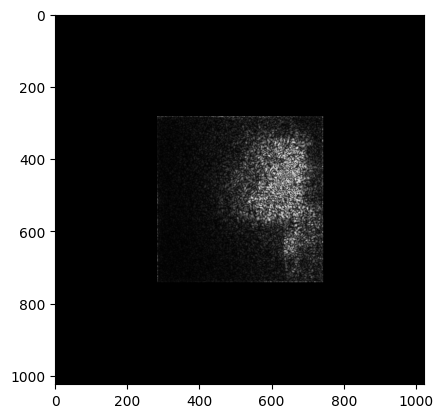

In [21]:
plt.imshow(fields[:,:,19], 'gray')

In [22]:
import napari
viewer = napari.Viewer()
viewer.add_image(fields[:,:,:20])

<Image layer 'Image' at 0x2071c14ffb0>